In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,  roc_auc_score
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import numpy as np
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('Telco_customer_churn_cleaned.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Streaming Music,Premium Tech Support,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Category
0,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Yes,0.00,0,20.94,129.09,1,Churned,Competitor
1,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Yes,0.00,0,18.24,169.89,2,Churned,Other
2,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,0.00,0,97.20,917.70,3,Churned,Other
3,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,0.00,0,136.92,3182.97,3,Churned,Other
4,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,0.00,0,2172.17,7208.47,1,Churned,Competitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,...,No,No,No,19.31,0,1639.44,3039.53,5,Stayed,0
7039,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,48.23,0,865.20,2807.47,3,Stayed,0
7040,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,45.38,0,2135.52,9453.04,4,Stayed,0
7041,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Yes,27.24,0,0.00,319.21,4,Stayed,0


# **1. 인과 그래프(DAG)**


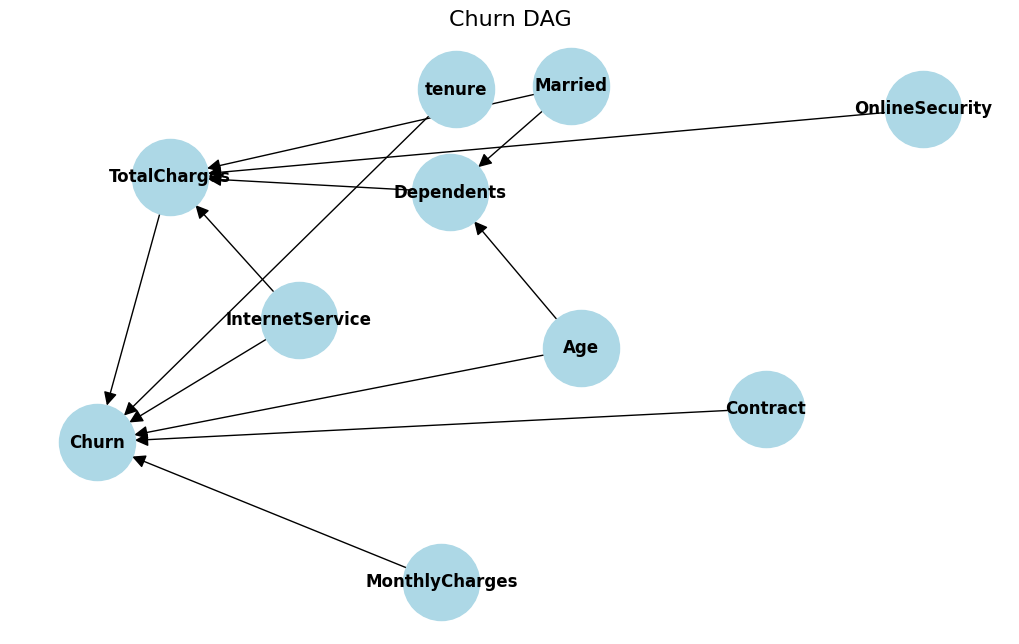

In [25]:
# 인과 관계를 나타내는 그래프 생성
G = nx.DiGraph()

# 노드 추가
nodes = ["tenure", "Contract",  "InternetService", "Churn","Age", "TotalCharges", "OnlineSecurity","Dependents", "Married"]
G.add_nodes_from(nodes)

# 엣지 추가
edges = [
    ("tenure", "Churn"),
    ("Contract", "Churn"),
    ("InternetService", "Churn"),
    ("InternetService", "TotalCharges"),
    ("OnlineSecurity", "TotalCharges"),
    ("Dependents", "TotalCharges"),
    ("Married", "TotalCharges"),
    ("TotalCharges", "Churn"),
    ("Married", "Dependents"),
    ("Age", "Churn"),
    ("Age", "Dependents"),
    # ("Contract", "PaymentMethod")
]
G.add_edges_from(edges)

# 그래프 시각화
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # 노드 위치 설정
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, font_weight="bold", arrowsize=20)
plt.title("Churn DAG", fontsize=16)
plt.show()

#**2. 데이터 전처리**

In [3]:
# 필요한 컬럼만 저장
columns_to_keep = ["tenure", "Contract",  "InternetService", "Churn","Age", "TotalCharges","PaymentMethod", "OnlineSecurity","Dependents", "Married"]
df1 = df[columns_to_keep]

In [4]:
# 인코딩 - 범주형 데이터
categorical_columns = df1.select_dtypes(include=['object']).columns

# 원핫인코딩
df1 = pd.get_dummies(df1, columns=categorical_columns)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   Age                                      7043 non-null   int64  
 2   TotalCharges                             7043 non-null   float64
 3   Contract_Month-to-month                  7043 non-null   bool   
 4   Contract_One year                        7043 non-null   bool   
 5   Contract_Two year                        7043 non-null   bool   
 6   InternetService_DSL                      7043 non-null   bool   
 7   InternetService_Fiber optic              7043 non-null   bool   
 8   InternetService_No                       7043 non-null   bool   
 9   Churn_No                                 7043 non-null   bool   
 10  Churn_Yes                                7043 no

In [6]:
# 스케일링

numerical_features = ['tenure',  'Age', 'TotalCharges']

# RobustScaler를 사용하여 수치형 변수 스케일링
scaler = RobustScaler()
df1[numerical_features] = scaler.fit_transform(df1[numerical_features])

# **3. 성향 점수 매칭 (Propensity Score Matching, PSM) 기법** - 교란 요인 제거를 위해
### **:  두 그룹 간의 기본적인 차이를 줄이고, 변수를 기준으로 유사한 개체들끼리 비교할 수 있도록 하는 것**

고객 이탈 여부를 예측할 때 이탈 그룹과 비이탈 그룹을 유사한 특성으로 매칭???

## **1. Propensity Score 계산**
 : 로지스틱 회귀 모델을 사용하여 각 고객이 이탈할 확률(Propensity Score)을 계산

## **2. Matching - 캘리퍼 매칭 사용**
 : 가장 유사한 Propensity Score를 가진 이탈 고객과 비이탈 고객을 매칭

### **# 캘리퍼매칭 (Caliper Matching)**
- 매칭되는 두 개체(실험군과 대조군)의 성향 점수 차이가 일정 범위(즉, 캘리퍼) 내에 있을 때만 매칭을 허용
-  매칭에 포함되지 않은 데이터는 분석에서 제외
- 이로 인해 매칭된 실험군과 대조군 간의 성향 점수 차이를 최소화

In [ ]:
# # 중위값을 기준으로 MonthlyCharges 실 변수 정의
# median_MonthlyCharges = df1['MonthlyCharges'].median()
# df1['treatment'] = np.where(df1['MonthlyCharges'] >= median_MonthlyCharges, 1, 0)

# # X와 y 정의
# X = df1.drop(columns=['Churn_No', 'Churn_Yes', 'treatment'])
# y = df1['treatment']

# # 로지스틱 회귀 모델을 사용하여 성향 점수 계산
# model = LogisticRegression(max_iter=1000)
# model.fit(X, y)
# df1['new_propensity_score'] = model.predict_proba(X)[:, 1]

In [ ]:
# # 데이터 프레임에서 실험군과 대조군 분리
# treatment_group = df1[df1['treatment'] == 1]
# control_group = df1[df1['treatment'] == 0]

# # 매칭을 위한 NN 모델 생성
# nn = NearestNeighbors(n_neighbors=1)
# nn.fit(control_group[['new_propensity_score']])

# # 각 실험군 샘플에 대해 가장 가까운 대조군 샘플 찾기
# distances, indices = nn.kneighbors(treatment_group[['new_propensity_score']])

# # 매칭된 대조군 샘플 선택
# matched_control_indices = indices.flatten()
# matched_control_group = control_group.iloc[matched_control_indices]

# # 매칭된 데이터 프레임 생성 (실험군 + 매칭된 대조군)
# matched_df1 = pd.concat([treatment_group, matched_control_group])

In [37]:
# 중위값을 기준으로 TotalCharges 실 변수 정의
median_TotalCharges = df1['TotalCharges'].median()
df1['treatment'] = np.where(df1['TotalCharges'] >= median_TotalCharges, 1, 0)

# 다변량 성향 점수 계산 - Propensity Score를 위한 로지스틱 회귀 모델
X = df1.drop(columns=['Churn_No', 'Churn_Yes','treatment'])
y = df1['Churn_Yes']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)
df1['propensity_score'] = model.predict_proba(X)[:, 1]

# 성향 점수 매칭 (캘리퍼매칭)
caliper = 0.1 * np.std(df1['propensity_score'])
treated = df1[df1['treatment'] == 1]
control = df1[df1['treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control_indices = indices.flatten()
caliper_mask = distances.flatten() <= caliper
matched_control_indices = matched_control_indices[caliper_mask]
matched_control = control.iloc[matched_control_indices]
matched_df1 = pd.concat([treated.iloc[caliper_mask], matched_control])
df

# 결과
treatment_churn_rate = matched_df1[matched_df1['treatment'] == 1]['Churn_Yes'].mean()
control_churn_rate = matched_df1[matched_df1['treatment'] == 0]['Churn_Yes'].mean()
print("Treatment churn rate:", treatment_churn_rate)
print("Control churn rate:", control_churn_rate)


Treatment churn rate: 0.18739352640545145
Control churn rate: 0.17319704713231118


In [38]:
# 매칭된 샘플의 수를 계산
matched_treated_count = treated.iloc[caliper_mask].shape[0]
matched_control_count = matched_control.shape[0]

print("매칭된 처치군 샘플 수:", matched_treated_count)
print("매칭된 대조군 샘플 수:", matched_control_count)

매칭된 처치군 샘플 수: 3522
매칭된 대조군 샘플 수: 3522


# 막대/히스토그램을 사용하여 PSM 적용 전후 성향 점수 분포 비교

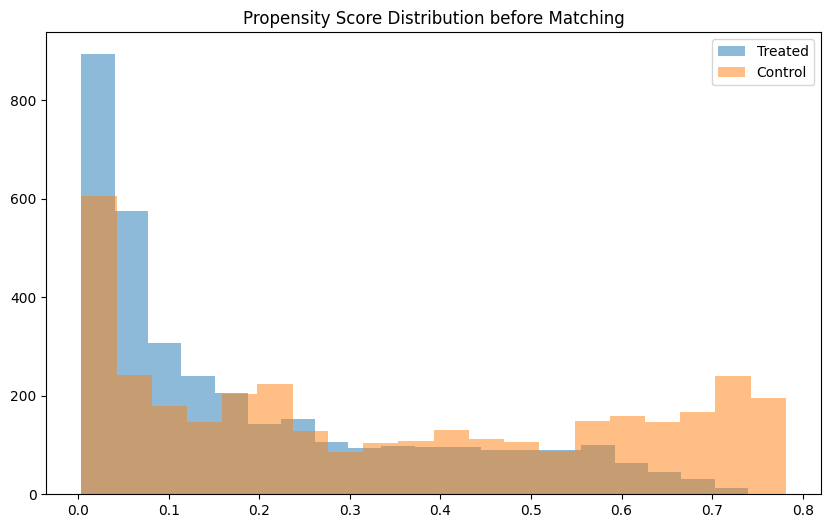

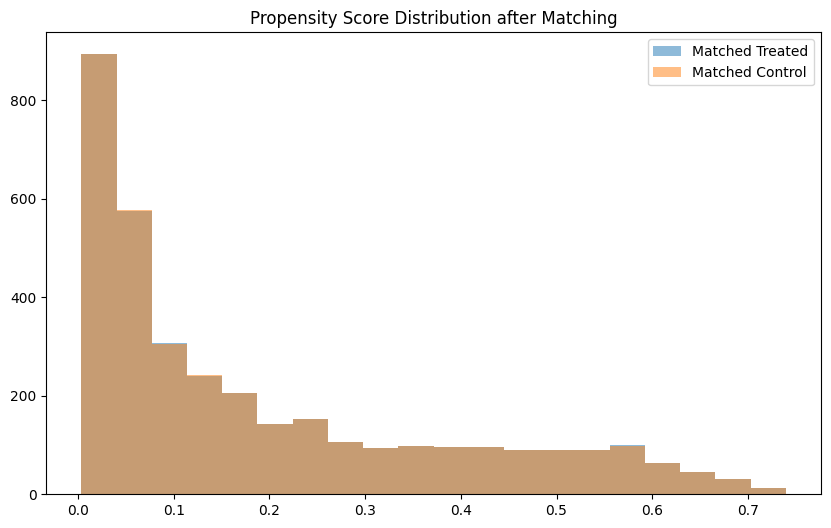

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(treated['propensity_score'], bins=20, alpha=0.5, label='Treated')
plt.hist(control['propensity_score'], bins=20, alpha=0.5, label='Control')
plt.title('Propensity Score Distribution before Matching')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(matched_treated['propensity_score'], bins=20, alpha=0.5, label='Matched Treated')
plt.hist(matched_control['propensity_score'], bins=20, alpha=0.5, label='Matched Control')
plt.title('Propensity Score Distribution after Matching')
plt.legend()
plt.show()


In [41]:
caliper = 0.05 * np.std(df1['propensity_score'])  # 더 좁은 캘리퍼

In [42]:
print("매칭된 샘플 수 확인:")
print("처치군:", matched_treated.shape[0])
print("대조군:", matched_control.shape[0])

매칭된 샘플 수 확인:
처치군: 3522
대조군: 3522


In [9]:
df1.columns

Index(['tenure', 'Age', 'TotalCharges', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'Churn_No',
       'Churn_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'Dependents_No', 'Dependents_Yes', 'Married_No',
       'Married_Yes', 'treatment', 'propensity_score'],
      dtype='object')

# Standardized Mean Difference (SMD):

- 각 변수에 대해 실험군과 대조군의 표준화된 평균 차이를 계산해서 매칭 후에도 두 그룹이 유사한지 평가하는 지표


Feature: tenure
           Treated      Control
count  3522.000000  3522.000000
mean      0.463861    -0.200615
std       0.375757     0.384678
min      -0.326087    -0.630435
25%       0.130435    -0.500000
50%       0.521739    -0.304348
75%       0.826087    -0.021739
max       0.934783     0.934783


Feature: Age
           Treated      Control
count  3522.000000  3522.000000
mean      0.058439    -0.097591
std       0.618497     0.543903
min      -0.964286    -0.964286
25%      -0.464286    -0.535714
50%       0.035714    -0.142857
75%       0.562500     0.321429
max       1.214286     1.214286


Feature: TotalCharges
           Treated      Control
count  3522.000000  3522.000000
mean      0.785213    -0.246066
std       0.575184     0.123056
min       0.000000    -0.411608
25%       0.264363    -0.357001
50%       0.706026    -0.270731
75%       1.243141    -0.145379
max       2.151754    -0.000280


Feature: Contract_Month-to-month
       Treated Control
count     3522    3522


<ipython-input-10-36f9a3ba9342>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(matched_treated['TotalCharges'], label='Treated', shade=True, color='blue')
<ipython-input-10-36f9a3ba9342>:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(matched_control['TotalCharges'], label='Control', shade=True, color='red')


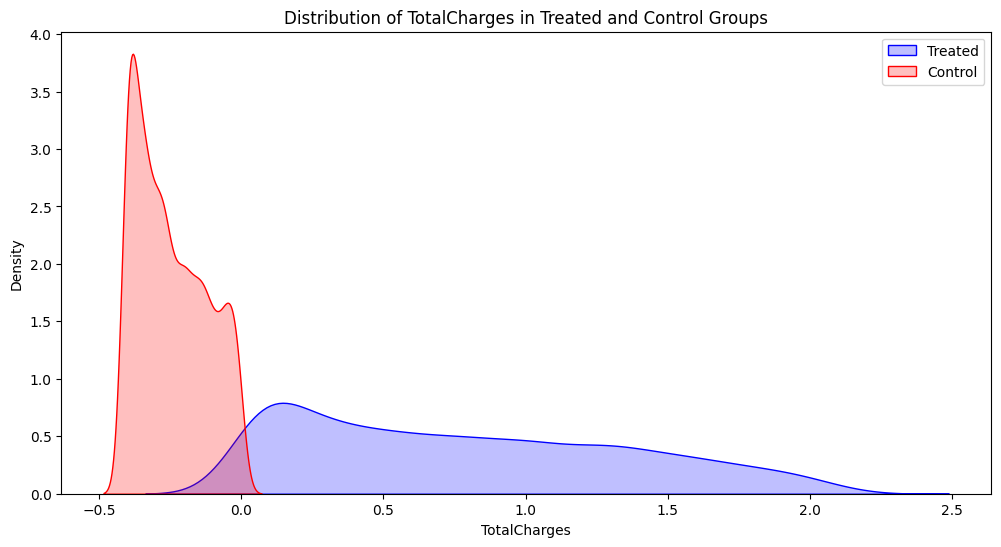

Standardized Mean Differences (SMD):
{'tenure': 1.7477473233786713, 'Age': 0.2679478294268803, 'TotalCharges': 2.4798637215595356, 'Contract_Month-to-month': -0.28314043064521277, 'Contract_One year': 0.012679751511055349, 'Contract_Two year': 0.3031192745016965, 'InternetService_DSL': 0.043851145427018144, 'InternetService_Fiber optic': 1.2134635552874573, 'InternetService_No': -1.3130037460832524, 'Churn_No': -0.030201494574918296, 'Churn_Yes': 0.030201494574918154, 'PaymentMethod_Bank transfer (automatic)': 0.2507153525383962, 'PaymentMethod_Credit card (automatic)': 0.21649705355559465, 'PaymentMethod_Electronic check': 0.28455400763915356, 'PaymentMethod_Mailed check': -0.7792325181177606, 'OnlineSecurity_No': 0.4005337508696945, 'OnlineSecurity_No internet service': -1.3130037460832524, 'OnlineSecurity_Yes': 0.7426288875552325, 'Dependents_No': 0.17456564161315866, 'Dependents_Yes': -0.17456564161315843, 'Married_No': -0.4119898893609468, 'Married_Yes': 0.41198988936094694}


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 매칭된 대조군과 실험군 데이터 분리
matched_treated = matched_df1[matched_df1['treatment'] == 1]
matched_control = matched_df1[matched_df1['treatment'] == 0]

# 주요 특성들에 대해 요약 통계 비교
def compare_groups(treated, control, features):
    summary = pd.DataFrame()
    for feature in features:
        treated_stats = treated[feature].describe().rename('Treated')
        control_stats = control[feature].describe().rename('Control')
        summary = pd.concat([treated_stats, control_stats], axis=1)
        print(f"Feature: {feature}")
        print(summary)
        print("\n")

# 주요 특성 리스트
features = ['tenure', 'Age', 'TotalCharges', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'Churn_No',
       'Churn_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'Dependents_No', 'Dependents_Yes', 'Married_No',
       'Married_Yes']

# 특성 비교
compare_groups(matched_treated, matched_control, features)

# 변수 분포 비교:  TotalCharges 변수 사용
plt.figure(figsize=(12, 6))
sns.kdeplot(matched_treated['TotalCharges'], label='Treated', shade=True, color='blue')
sns.kdeplot(matched_control['TotalCharges'], label='Control', shade=True, color='red')
plt.title('Distribution of TotalCharges in Treated and Control Groups')
plt.xlabel('TotalCharges')
plt.ylabel('Density')
plt.legend()
plt.show()

# Standardized Mean Difference (SMD) 계산
def calculate_smd(treated, control, features):
    smd = {}
    for feature in features:
        mean_diff = np.mean(treated[feature]) - np.mean(control[feature])
        pooled_std = np.sqrt((np.var(treated[feature]) + np.var(control[feature])) / 2)
        smd[feature] = mean_diff / pooled_std
    return smd



# SMD 계산 & 결과
smd = calculate_smd(matched_treated, matched_control, features)
print("Standardized Mean Differences (SMD):")
print(smd)


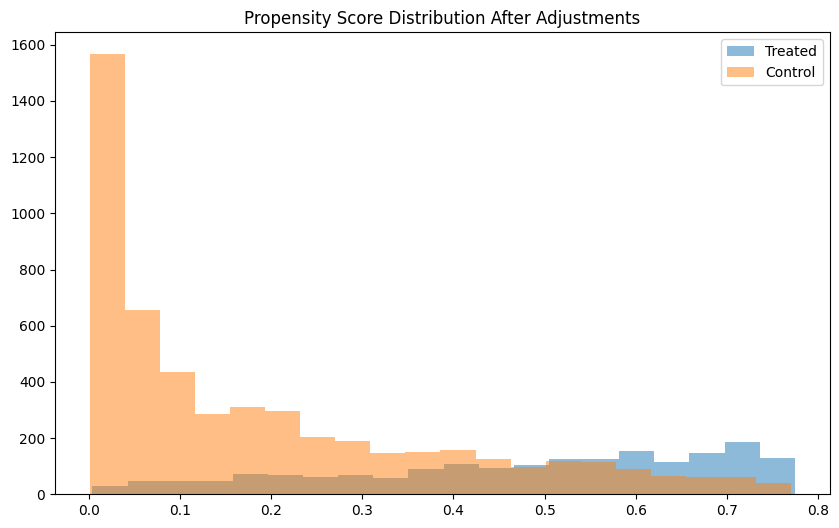

In [11]:
# 성향 점수 분포 재확인 후 매칭 시도
plt.figure(figsize=(10, 6))
plt.hist(df1[df1['Churn_Yes'] == True]['propensity_score'], bins=20, alpha=0.5, label='Treated')
plt.hist(df1[df1['Churn_Yes'] == False]['propensity_score'], bins=20, alpha=0.5, label='Control')
plt.legend(loc='upper right')
plt.title('Propensity Score Distribution After Adjustments')
plt.show()

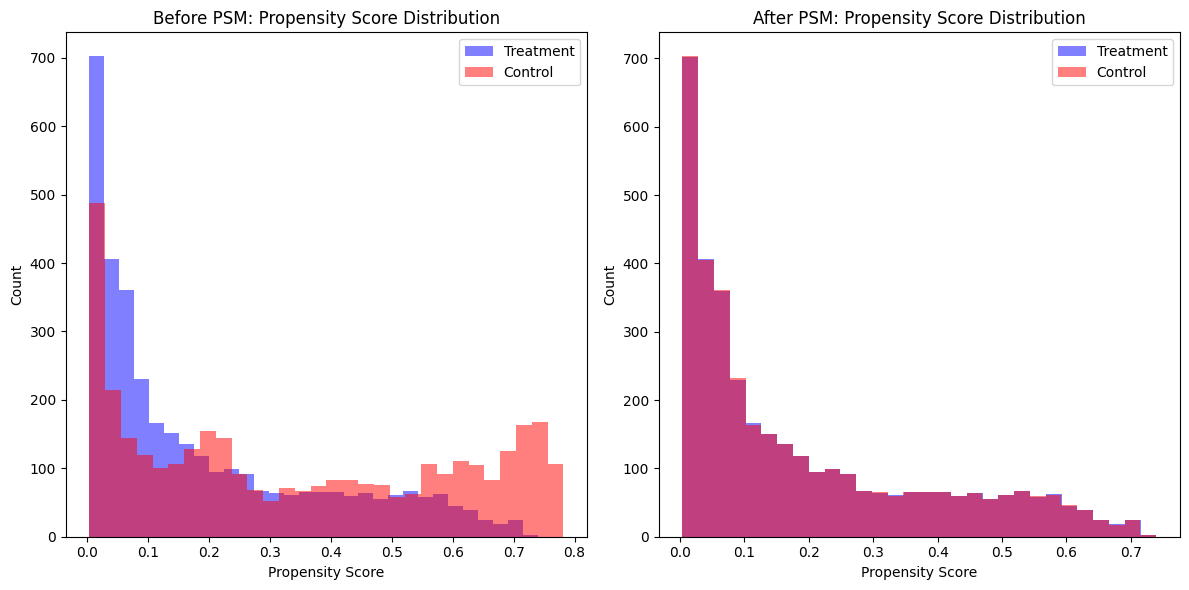

In [49]:
# 히스토그램을 사용하여 PSM 적용 전/후 성향 점수 분포 비교

plt.figure(figsize=(12, 6))

# PSM 적용 전 성향 점수 분포
plt.subplot(1, 2, 1)
plt.hist(df1[df1['treatment'] == 1]['propensity_score'], bins=30, alpha=0.5, label='Treatment', color='blue')
plt.hist(df1[df1['treatment'] == 0]['propensity_score'], bins=30, alpha=0.5, label='Control', color='red')
plt.title('Before PSM: Propensity Score Distribution')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()

# PSM 적용 후 성향 점수 분포
plt.subplot(1, 2, 2)
plt.hist(matched_df1[matched_df1['treatment'] == 1]['propensity_score'], bins=30, alpha=0.5, label='Treatment', color='blue')
plt.hist(matched_df1[matched_df1['treatment'] == 0]['propensity_score'], bins=30, alpha=0.5, label='Control', color='red')
plt.title('After PSM: Propensity Score Distribution')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

# QQ plot을 사용하여 PSM 적용 전/후 성향 점수 분포 비교

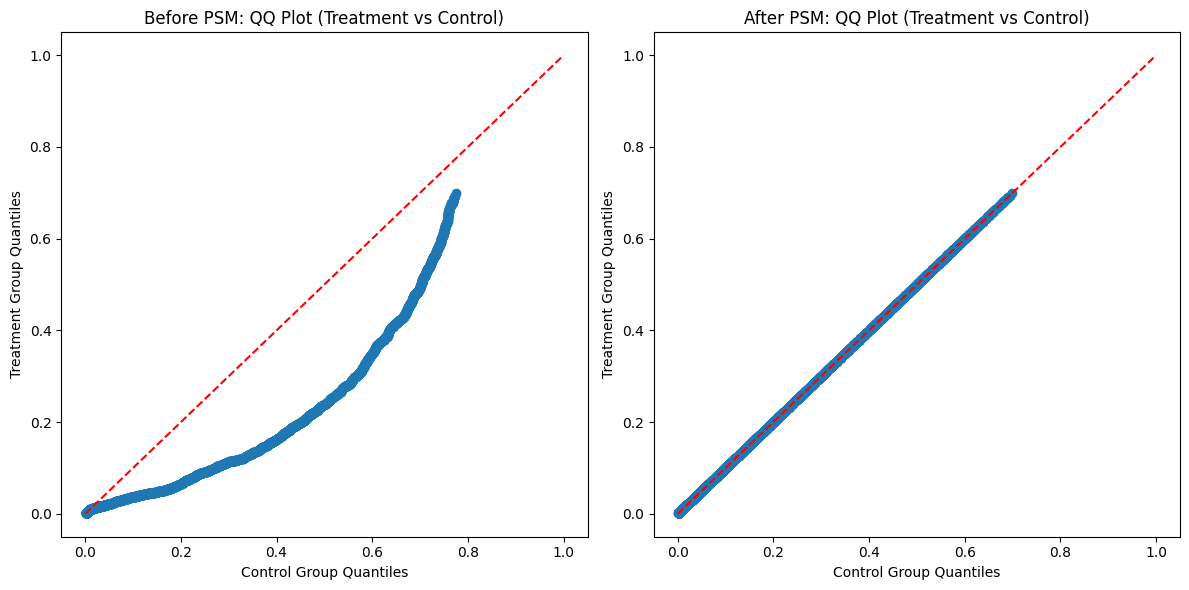

In [15]:
# 최소 크기에 맞추기 위해 데이터 샘플링
min_size = min(len(df1[df1['treatment'] == 1]), len(df1[df1['treatment'] == 0]))

# 실험군과 대조군의 성향 점수 정렬 후 샘플링
treated_scores = df1[df1['treatment'] == 1]['propensity_score'].sort_values().head(min_size)
control_scores = df1[df1['treatment'] == 0]['propensity_score'].sort_values().head(min_size)

# PSM 적용 후 동일하게 처리
treated_scores_matched = matched_df1[matched_df1['treatment'] == 1]['propensity_score'].sort_values().head(min_size)
control_scores_matched = matched_df1[matched_df1['treatment'] == 0]['propensity_score'].sort_values().head(min_size)

# QQ 플롯 그리기
plt.figure(figsize=(12, 6))

# PSM 적용 전 QQ 플롯 (실험군 vs 대조군)
plt.subplot(1, 2, 1)
plt.plot(control_scores, treated_scores, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Before PSM: QQ Plot (Treatment vs Control)')
plt.xlabel('Control Group Quantiles')
plt.ylabel('Treatment Group Quantiles')

# PSM 적용 후 QQ 플롯 (실군 vs 대조군)
plt.subplot(1, 2, 2)
plt.plot(control_scores_matched, treated_scores_matched, 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('After PSM: QQ Plot (Treatment vs Control)')
plt.xlabel('Control Group Quantiles')
plt.ylabel('Treatment Group Quantiles')

plt.tight_layout()
plt.show()


#**4. 실험군과 대조군의 이탈 여부 평균 계산**

In [16]:
# 매칭된 데이터 프레임에서 실군과 대조군의 이탈 여부 평균 계산
treatment_churn_rate = matched_df1[matched_df1['treatment'] == 1]['Churn_Yes'].mean()
control_churn_rate = matched_df1[matched_df1['treatment'] == 0]['Churn_Yes'].mean()

# 결과
treatment_churn_rate, control_churn_rate

(0.18739352640545145, 0.17575241340147643)

In [17]:
# PSM 적용 전의 이탈률 계산 (실험군과 대조군)
pre_psm_treatment_churn_rate = df1[df1['treatment'] == 1]['Churn_Yes'].mean()
pre_psm_control_churn_rate = df1[df1['treatment'] == 0]['Churn_Yes'].mean()

# 결과
pre_psm_treatment_churn_rate, pre_psm_control_churn_rate


(0.18739352640545145, 0.3433683612610054)

1. TotalCharges 외의 다른 변수들이 두 그룹 간의 차이를 만들어냈을 가능성이 높다.
2. TotalCharges 자체가 이탈률에 큰 영향을 미치지 않는다

In [18]:
from scipy.stats import chi2_contingency

# 실군과 대조군의 이탈률을 비교하기 위해
contingency_table = pd.crosstab(matched_df1['treatment'], matched_df1['Churn_Yes'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("p-value:", p_value)

p-value: 0.2163355758993024


p-value가 0.05보다 크기 때문에 두 그룹 간의 이탈률 차이가 통계적으로 유의미하지 않다고 해석됨.
=>  TotalCharges가 이탈률에 큰 영향X

# **결론 :**
PSM 적용 후 이탈률의 차이가 거의 없어졌다는 것은, TotalCharges가 이탈률에 미치는 직접적인 영향이 없거나 매우 작을 수 있다는 것을 의미. 따라서, "TotalCharges가 높을수록 이탈률이 높다"는 가설은 PSM 분석 결과에 의해 지지되지 않는다고 해석할 수 있다.

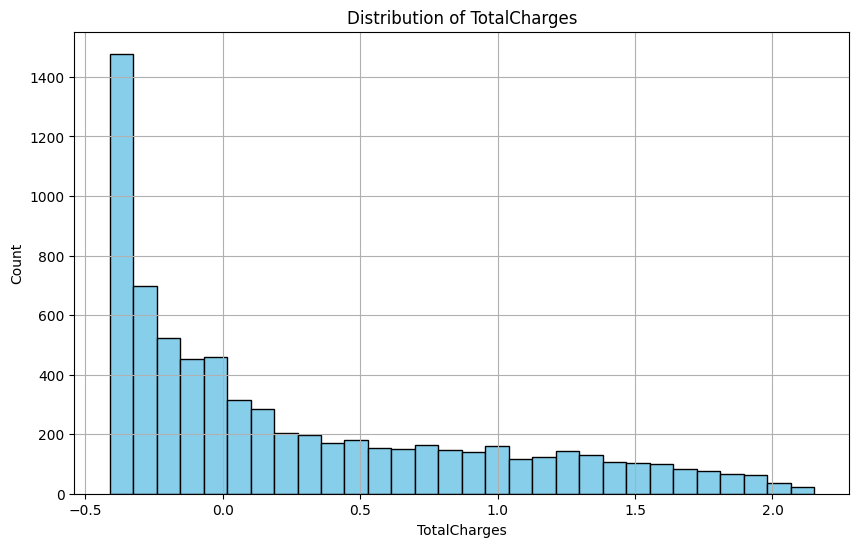

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(df1['TotalCharges'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [45]:
df1

,tenure,Age,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Churn_No,...,PaymentMethod_Mailed check,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Dependents_No,Dependents_Yes,Married_No,Married_Yes,treatment,propensity_score
0,-0.586957,-0.321429,-0.379687,True,False,False,True,False,False,False,...,True,False,False,True,True,False,True,False,0,0.295552
1,-0.586957,-0.964286,-0.366848,True,False,False,False,True,False,False,...,False,True,False,False,True,False,True,False,0,0.698948
2,-0.456522,-0.535714,-0.169434,True,False,False,False,True,False,False,...,False,True,False,False,True,False,True,False,0,0.692644
3,-0.021739,-0.821429,0.487449,True,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,1,0.595942
4,0.434783,-0.285714,1.074881,True,False,False,False,True,False,False,...,False,True,False,False,True,False,True,False,1,0.367481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.934783,-0.571429,0.007335,False,False,True,False,False,True,True,...,False,False,True,False,True,False,True,False,1,0.004114
7039,-0.108696,-0.285714,0.175898,False,True,False,True,False,False,True,...,True,False,False,True,False,True,False,True,1,0.094311
7040,0.934783,-0.571429,1.761589,False,True,False,False,True,False,True,...,False,True,False,False,False,True,False,True,1,0.115384
7041,-0.391304,-0.500000,-0.309352,True,False,False,True,False,False,True,...,False,False,False,True,False,True,False,True,0,0.244247
